In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from datetime import datetime


In [2]:
df = pd.read_csv('Realisierte_Erzeugung_201501010000_202412020000_Viertelstunde.csv',sep=';')

In [3]:
df.head()

,Datum von,Datum bis,Biomasse [MWh] Originalauflösungen,Wasserkraft [MWh] Originalauflösungen,Wind Offshore [MWh] Originalauflösungen,Wind Onshore [MWh] Originalauflösungen,Photovoltaik [MWh] Originalauflösungen,Sonstige Erneuerbare [MWh] Originalauflösungen,Kernenergie [MWh] Originalauflösungen,Braunkohle [MWh] Originalauflösungen,Steinkohle [MWh] Originalauflösungen,Erdgas [MWh] Originalauflösungen,Pumpspeicher [MWh] Originalauflösungen,Sonstige Konventionelle [MWh] Originalauflösungen
0,01.01.2015 00:00,01.01.2015 00:15,"1.005,50","288,25","130,00","2.028,25","0,00","33,25","2.685,50","3.964,75","805,50","317,25","391,00","1.235,00"
1,01.01.2015 00:15,01.01.2015 00:30,"1.007,00","287,75","129,25","2.023,00","0,00","33,25","2.646,25","3.950,75","833,00","316,25","373,25","1.213,75"
2,01.01.2015 00:30,01.01.2015 00:45,"1.006,50","292,75","128,50","2.040,25","0,00","33,25","2.660,75","3.912,25","806,25","313,50","426,50","1.218,50"
3,01.01.2015 00:45,01.01.2015 01:00,"1.005,25","289,50","128,75","2.036,50","0,00","33,25","2.718,00","3.859,50","775,00","279,25","335,00","1.242,00"
4,01.01.2015 01:00,01.01.2015 01:15,"999,00","295,25","128,75","2.045,75","0,00","33,25","2.772,25","3.888,00","633,50","261,50","247,50","1.247,25"


In [4]:
# Select the six columns we discussed
columns_of_interest = [
    'Wasserkraft [MWh] Originalauflösungen', 
    'Wind Offshore [MWh] Originalauflösungen', 
    'Wind Onshore [MWh] Originalauflösungen', 
    'Photovoltaik [MWh] Originalauflösungen', 
    'Braunkohle [MWh] Originalauflösungen', 
    'Erdgas [MWh] Originalauflösungen'
]

# Convert 'Datum von' to datetime
df['Datum von'] = pd.to_datetime(df['Datum von'], format='%d.%m.%Y %H:%M')

# Extract hour from the timestamp
df['Hour'] = df['Datum von'].dt.hour

# Group by hour and sum the production for each energy source
hourly_production = df.groupby('Hour')[columns_of_interest].sum()



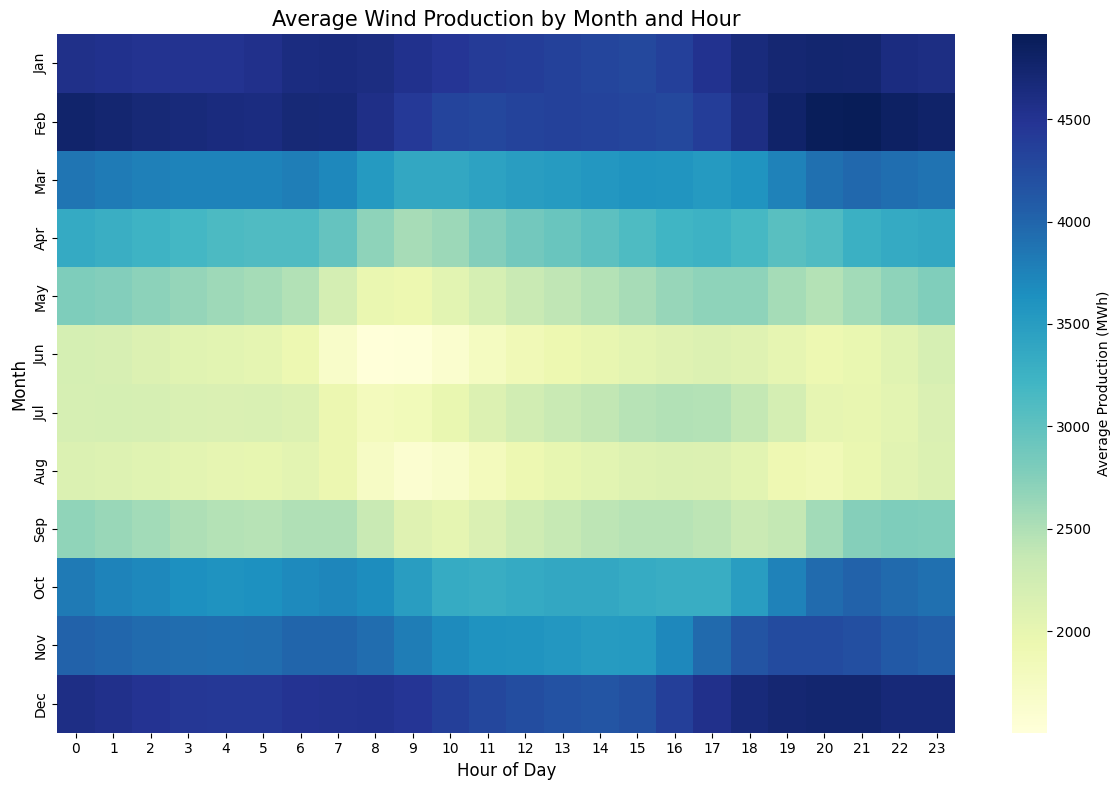

In [10]:
# Combine Wind Offshore and Wind Onshore
df['Total Wind [MWh]'] = pd.to_numeric(df['Wind Offshore [MWh] Originalauflösungen'].str.replace('.','').str.replace(',','.')) + \
                         pd.to_numeric(df['Wind Onshore [MWh] Originalauflösungen'].str.replace('.','').str.replace(',','.'))

# Extract month from the timestamp if not already done
df['Month'] = df['Datum von'].dt.month

# Create pivot table with hours as columns and months as rows, using mean of total wind production
pivot_wind = pd.pivot_table(
    data=df, 
    values='Total Wind [MWh]',
    index='Month',
    columns='Hour',
    aggfunc='mean'
)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_wind,
    cmap='YlGnBu', 
    cbar_kws={'label': 'Average Production (MWh)'},
    xticklabels=range(24),
    yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

plt.title('Average Wind Production by Month and Hour', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.tight_layout()
plt.show()

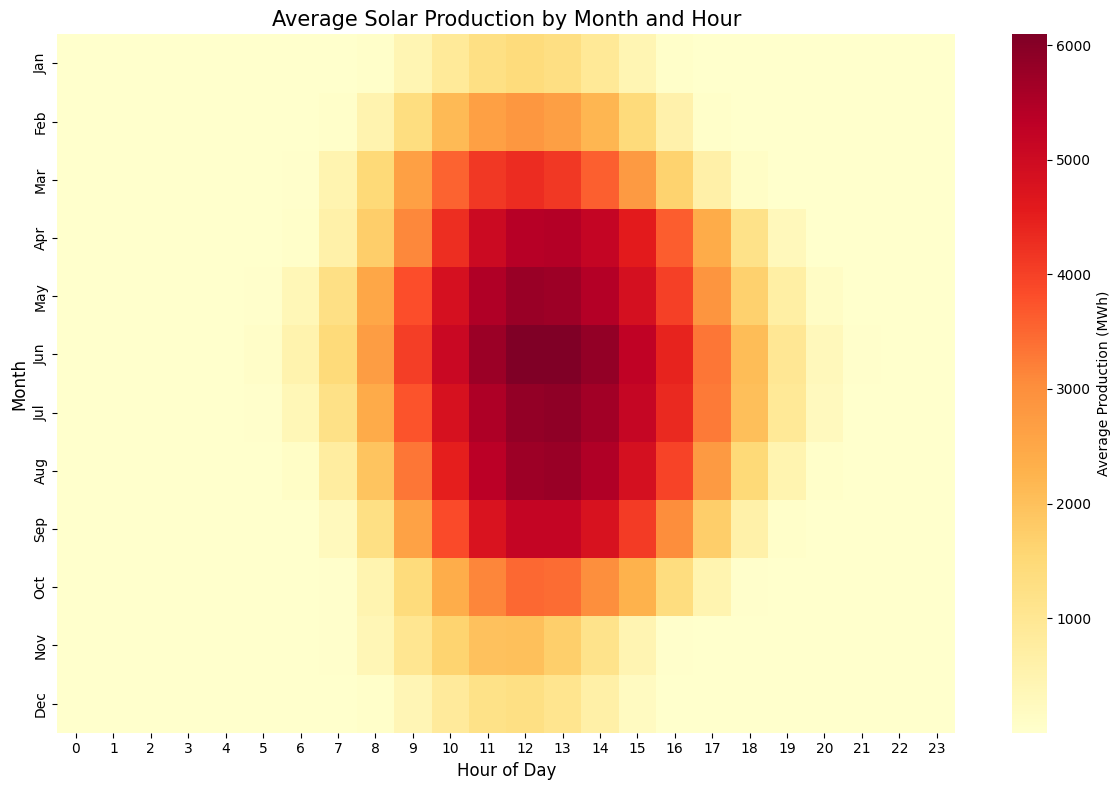

In [8]:
# Convert the string values to numeric, replacing German number format
df['Photovoltaik [MWh] Originalauflösungen'] = pd.to_numeric(
    df['Photovoltaik [MWh] Originalauflösungen'].str.replace('.','').str.replace(',','.'),
    errors='coerce'
)

# Create pivot table with hours as columns and months as rows, using mean of Photovoltaik production
pivot_pv = pd.pivot_table(
    data=df,
    values='Photovoltaik [MWh] Originalauflösungen',
    index='Month',
    columns='Hour',
    aggfunc='mean'
)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_pv,
    cmap='YlOrRd',  # Yellow-Orange-Red colormap
    cbar_kws={'label': 'Average Production (MWh)'},
    xticklabels=range(24),
    yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

plt.title('Average Solar Production by Month and Hour', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.tight_layout()
plt.show()

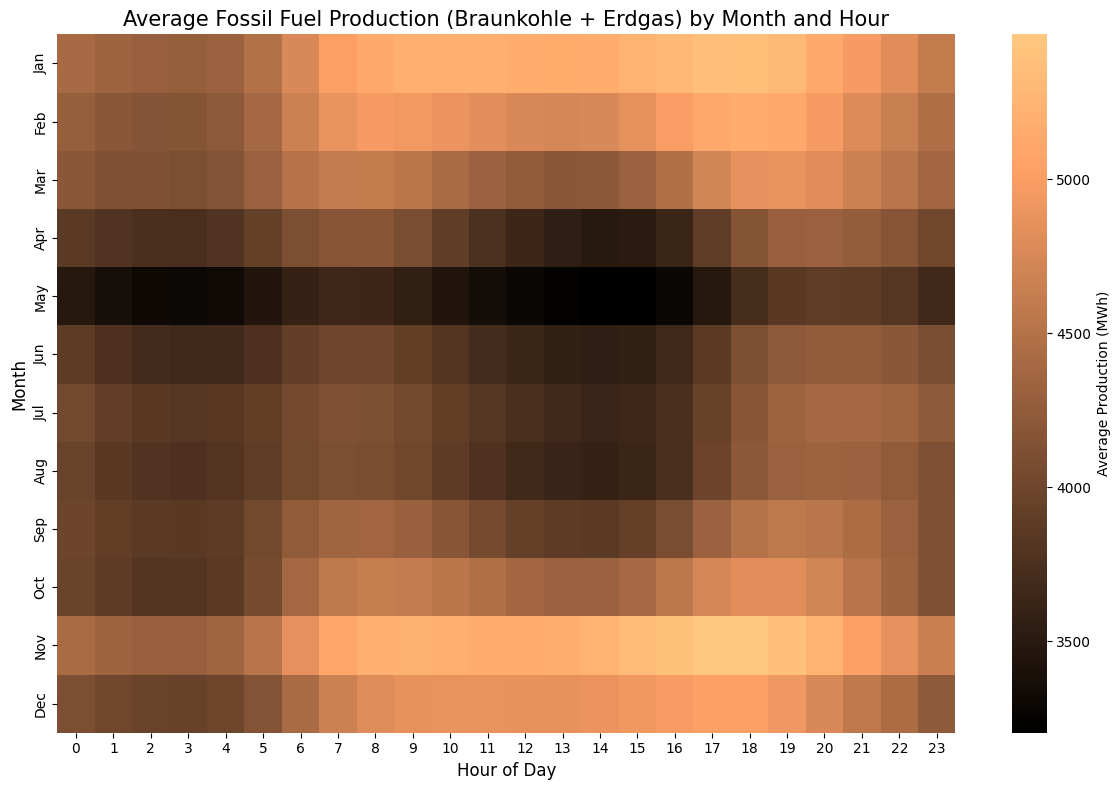

In [12]:
# Combine Braunkohle and Erdgas
df['Total Fossil [MWh]'] = pd.to_numeric(df['Braunkohle [MWh] Originalauflösungen'].str.replace('.','').str.replace(',','.')) + \
                          pd.to_numeric(df['Erdgas [MWh] Originalauflösungen'].str.replace('.','').str.replace(',','.'))

# Create pivot table with hours as columns and months as rows, using mean of total fossil production
pivot_fossil = pd.pivot_table(
    data=df, 
    values='Total Fossil [MWh]',
    index='Month',
    columns='Hour',
    aggfunc='mean'
)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_fossil,
    cmap='copper',  # Using Reds colormap for fossil fuels
    cbar_kws={'label': 'Average Production (MWh)'},
    xticklabels=range(24),
    yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

plt.title('Average Fossil Fuel Production (Braunkohle + Erdgas) by Month and Hour', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.tight_layout()
plt.show()

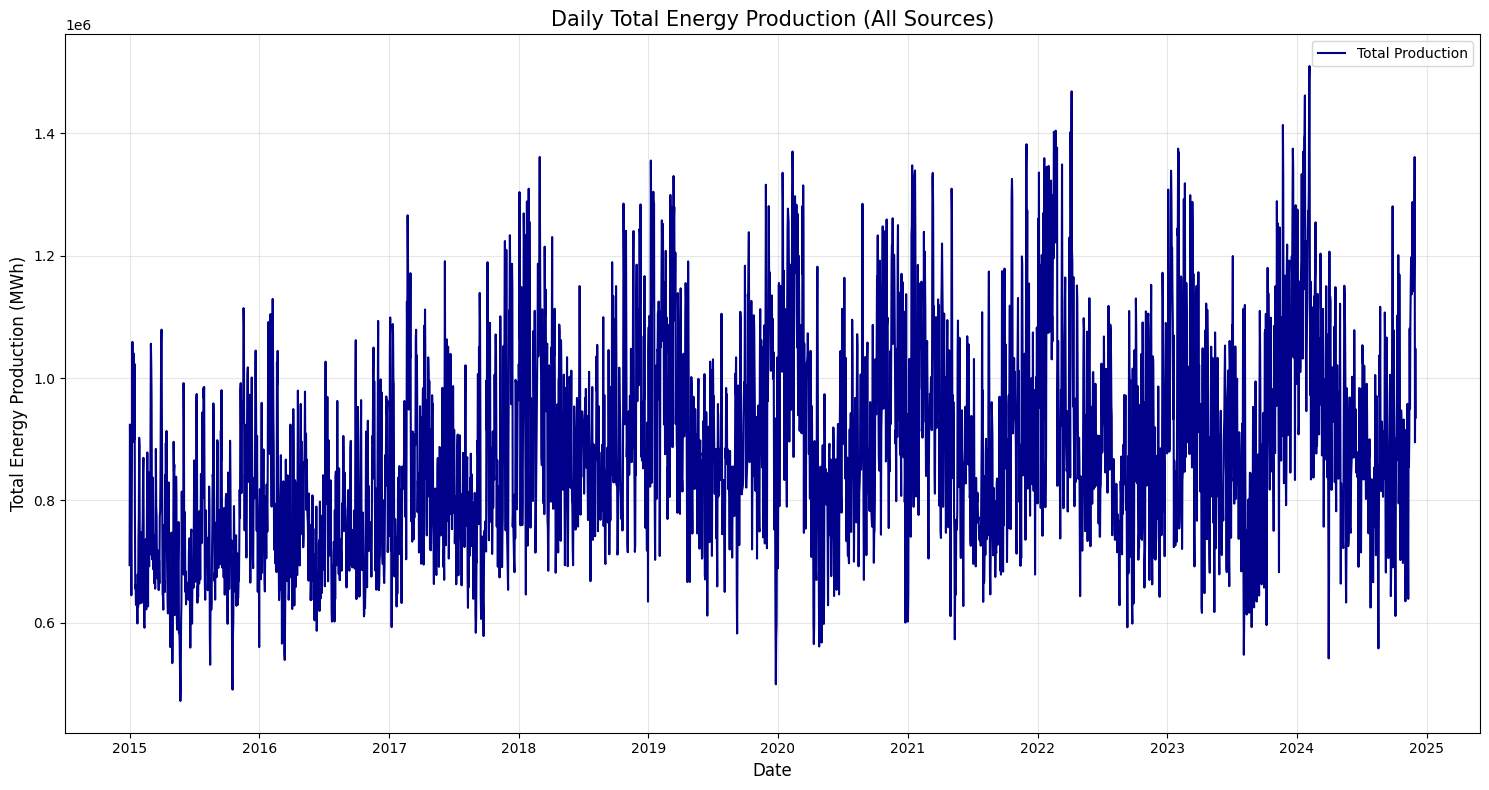

In [ ]:
# Calculate total energy production by summing all sources
energy_sources = [
    'Wasserkraft [MWh] Originalauflösungen',
    'Wind Offshore [MWh] Originalauflösungen',
    'Wind Onshore [MWh] Originalauflösungen',
    'Photovoltaik [MWh] Originalauflösungen',
    'Braunkohle [MWh] Originalauflösungen',
    'Erdgas [MWh] Originalauflösungen'
]

# Calculate total energy production by summing all energy sources
df_daily = df.resample('D', on='Datum von')[energy_sources].sum()

# Create the plot
plt.figure(figsize=(15, 8))

# Plot the total production over time
plt.plot(df_daily.index, df_daily.sum(axis=1), label='Total Production', color='darkblue')

plt.title('Daily Total Energy Production (All Sources)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Energy Production (MWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
# Extract day of the week from the timestamp (0 = Monday, 6 = Sunday)
df['Day_of_Week'] = df['Datum von'].dt.dayofweek

# Group by day of the week and sum the production for each energy source
weekly_production = df.groupby('Day_of_Week')[columns_of_interest].sum()

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot each energy source
for column in columns_of_interest:
    plt.plot(weekly_production.index, weekly_production[column], label=column)

plt.title('Typical Weekly Energy Production', fontsize=15)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Energy Production (MWh)', fontsize=12)
plt.xticks(weekly_production.index, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\TimPr\AppData\Local\Temp\ipykernel_29020\4208396429.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


ValueError: Image size of 2671304x549 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x600 with 1 Axes>

: 

In [ ]:
# Extract month from the timestamp
df['Month'] = df['Datum von'].dt.month

# Group by month and sum the production for each energy source
monthly_production = df.groupby('Month')[columns_of_interest].sum()

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot each energy source
for column in columns_of_interest:
    plt.plot(monthly_production.index, monthly_production[column], label=column)

plt.title('Typical Yearly Energy Production', fontsize=15)
plt.xlabel('Month of Year', fontsize=12)
plt.ylabel('Energy Production (MWh)', fontsize=12)
plt.xticks(monthly_production.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\TimPr\AppData\Local\Temp\ipykernel_3188\3995190664.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M', on='Datum von')[columns_of_interest].sum()


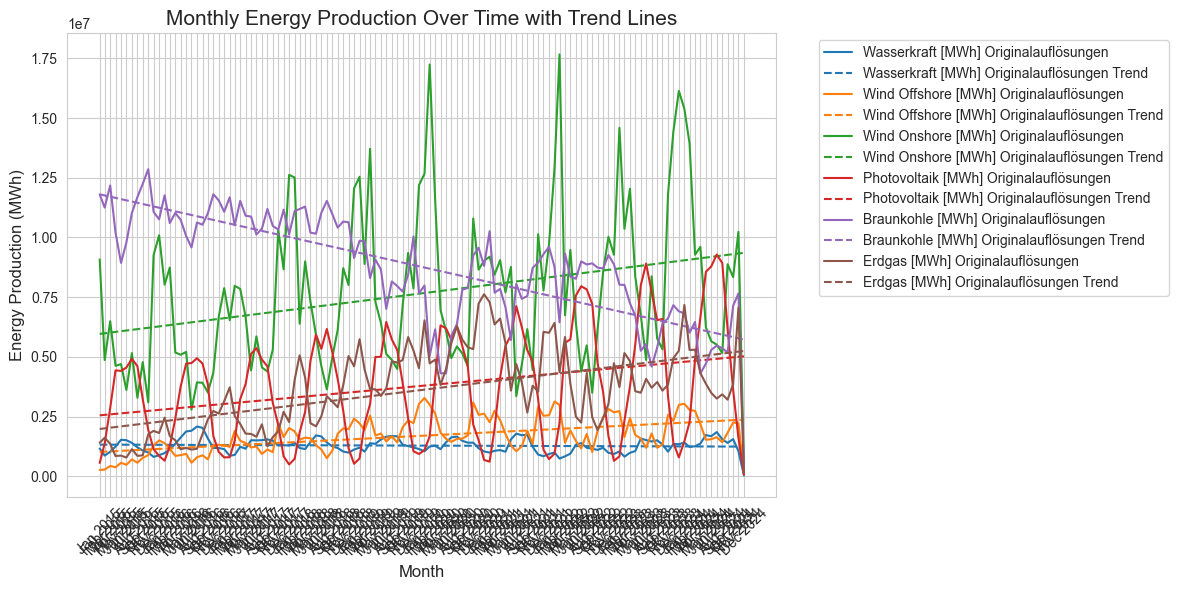

In [29]:
from scipy.stats import linregress

# Resample the data to monthly frequency, summing up the production for each energy source
df_monthly = df.resample('M', on='Datum von')[columns_of_interest].sum()

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot each energy source for monthly aggregation and add a trend line
for i, column in enumerate(columns_of_interest):
    # Plot the original line
    line, = plt.plot(df_monthly.index, df_monthly[column], label=column)
    
    # Extract the color of the current line
    line_color = line.get_color()
    
    # Convert datetime index to numeric (timestamp in seconds)
    numeric_dates = df_monthly.index.astype('int64') // 10**9  # Convert to seconds for linregress

    # Calculate trend line using linear regression (linregress)
    slope, intercept, _, _, _ = linregress(numeric_dates, df_monthly[column])
    trend_line = slope * numeric_dates + intercept
    
    # Plot the trend line with the same color as the original line
    plt.plot(df_monthly.index, trend_line, linestyle='--', color=line_color, label=f'{column} Trend')

plt.title('Monthly Energy Production Over Time with Trend Lines', fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Energy Production (MWh)', fontsize=12)
plt.xticks(df_monthly.index, df_monthly.index.strftime('%b %Y'), rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


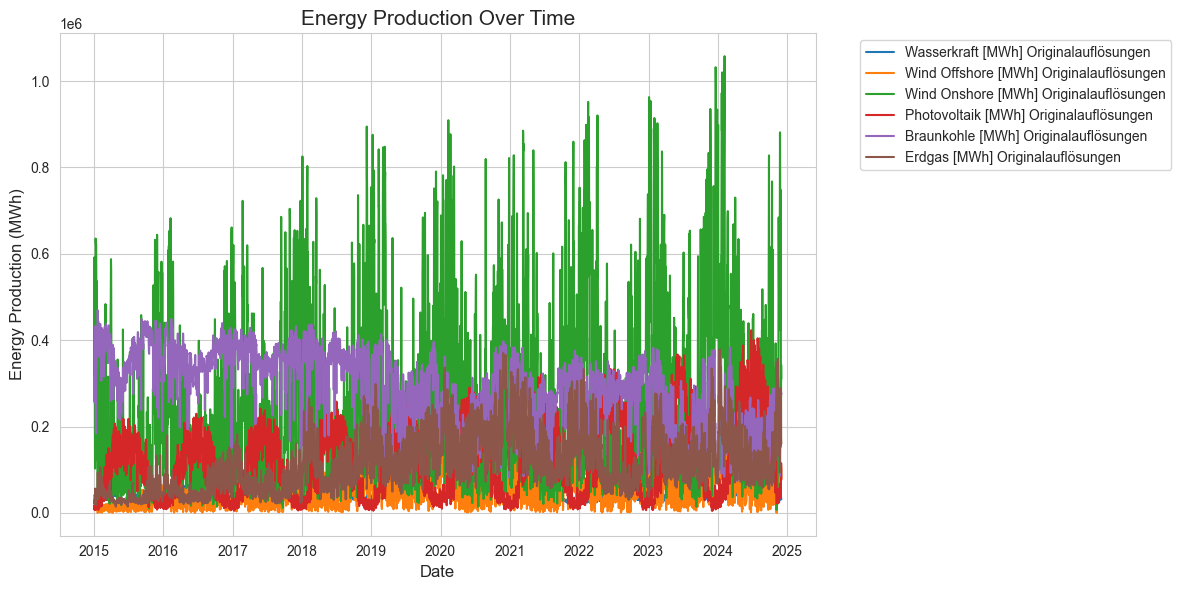

In [24]:
# Group by the 'Datum von' (timestamp) and sum the production for each energy source
df_resampled = df.resample('D', on='Datum von')[columns_of_interest].sum()  # Daily aggregation

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot each energy source over time
for column in columns_of_interest:
    plt.plot(df_resampled.index, df_resampled[column], label=column)

plt.title('Energy Production Over Time', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Production (MWh)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\TimPr\AppData\Local\Temp\ipykernel_3188\830961913.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.resample('Y', on='Datum von')[columns_of_interest].sum()


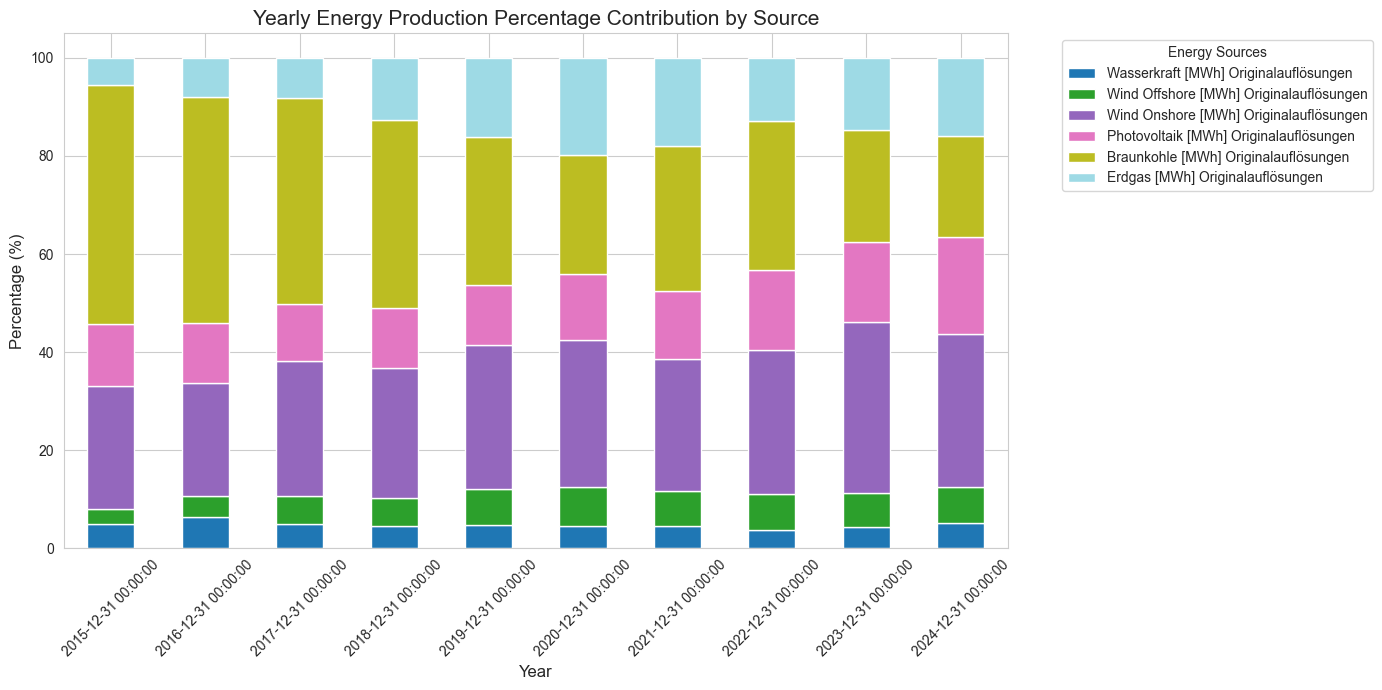

In [30]:
# Resample the data to yearly frequency, summing up the production for each energy source
df_yearly = df.resample('Y', on='Datum von')[columns_of_interest].sum()

# Calculate the total production for each year
df_yearly['Total'] = df_yearly.sum(axis=1)

# Calculate the percentage contribution of each energy source to the total production
df_percentage = df_yearly[columns_of_interest].div(df_yearly['Total'], axis=0) * 100

# Create the bar plot
df_percentage.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20')

plt.title('Yearly Energy Production Percentage Contribution by Source', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Energy Sources', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [1]:
# Create pivot table with hours as columns and months as rows, using mean of Photovoltaik production
pivot_pv = pd.pivot_table(
    data=df,
    values='Photovoltaik [MWh] Originalauflösungen',
    index='Month',
    columns='Hour',
    aggfunc='mean'
)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_pv,
    cmap='YlOrRd',
    cbar_kws={'label': 'Average Production (MWh)'},
    xticklabels=range(24),
    yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

plt.title('Average Solar Production by Month and Hour', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined

In [ ]:
# Create pivot table with hours as columns and months as rows, using mean of Photovoltaik production
pivot_pv = pd.pivot_table(
    data=df,
    values='Photovoltaik [MWh] Originalauflösungen',
    index='Month',
    columns='Hour',
    aggfunc='mean'
)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_pv,
    cmap='YlOrRd',
    cbar_kws={'label': 'Average Production (MWh)'},
    xticklabels=range(24),
    yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

plt.title('Average Solar Production by Month and Hour', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.tight_layout()
plt.show()